Assuming transmission line along $x=0$ to $x=L$  
## Ricatti Differential Equation  
Ricatti equation in terms of $\epsilon(x)$ and $\Gamma(x)$  
$$\Gamma_\omega'(x)-j\omega\epsilon(x)\Gamma_\omega(x)-\frac{\epsilon'(x)}{2\epsilon(x)}(1-\Gamma_\omega^2(x))=0$$

The given formula can be approximated a Fourier Transform relation between reflection coeff at the start and epsilon along the line  
For small $\Gamma(x)$, we approximate the Ricatti as
$$\Gamma'_\omega(x)-j\omega\epsilon(x)\Gamma_\omega(x)-\frac{\epsilon'(x)}{2\epsilon(x)}=0$$

Asumme matched line at load, $\Gamma(\omega, L) =0$. The Ricatti solution at $x=0$ is given by

$$\Gamma_\omega(0) = -\int_0^L\frac{\epsilon'(x)}{2\epsilon(x)}exp\left[-j\omega\int_0^x\epsilon(u)du\right]dx$$

Let $y(x) = \int_0^x\epsilon(u)du$ (monotonically increasing so $x(y)\exists$). Then we have  
$$\Gamma_w(0)=-\int_0^L\frac{\epsilon'(x)}{2\epsilon^2(x)}e^{-j\omega y}dx$$  
$$\Gamma_w(0)=-\int_0^{y_L}\frac{\epsilon'(x(y))}{2\epsilon^2(x(y))}e^{-j\omega y}dy$$  


Denote 
$$\phi(y)=-\frac{\epsilon'(x(y))}{2\epsilon^2(x(y))}$$  


We have the following fourier transform pair  
$$\Gamma_\omega(0)\leftrightarrow \phi(y)$$  


DE for $\epsilon(x)$  
$$-\frac{\epsilon'(x)}{2\epsilon^2(x)}=\phi\left(\int_0^x\epsilon(x)dx\right)$$  
Substitute $y=\int_0^x\epsilon(u)du$  
$$-\frac{y''}{2y'^2}=\phi(y)$$  
$y(0)=0$, $y'(0)=\epsilon(0)$

# Required Functions

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import constants, integrate, signal
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.signal import butter, freqz
from scipy.misc import derivative
import scipy.fft
import skrf as rf
import pandas as pd

In [107]:
L = 200e-6
eps0 = constants.epsilon_0
mu0 = constants.mu_0

In [108]:
%config InlineBackend.figure_format = 'svg'
plt.rcParams['lines.linewidth'] = 0.8

In [109]:
def plot_resp_logy(x, y, title_name): # prints the freq response with dB on y axis
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.semilogx(x, 20 * np.log10(abs(y)))
    plt.title(title_name)
    plt.ylabel('Magnitude (dB)')


    plt.subplot(2, 1, 2)
    plt.semilogx(x, np.angle(y))
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Phase (rad)')


def plot_resp(x, y, title_name): # prints the freq response with dB on y axis
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.semilogx(x, abs(y))
    plt.title(title_name)
    plt.ylabel('Magnitude (linear)')


    plt.subplot(2, 1, 2)
    plt.semilogx(x, np.angle(y))
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Phase (rad)')

def plot_real_imag(x, y, title_name):
    plt.figure()
    plt.plot(x, np.real(y), label='real part')
    plt.plot(x, np.imag(y), label='imaginary part')
    plt.legend()
    plt.title(title_name)
    plt.xlabel('x points')


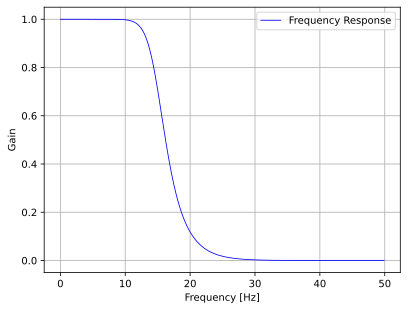

In [110]:
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Filter parameters
fs = 100.0  # Sample rate (Hz)
cutoff_freq = 15.0  # Desired cutoff frequency (Hz)
order = 6  # Filter order

# Compute the frequency response of the filter
b, a = butter_lowpass(cutoff_freq, fs, order=order)
w, Gamma0 = freqz(b, a, fs=fs)

plt.figure()
plt.plot(w, abs(Gamma0), 'b-', label='Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid(True)
plt.legend()
plt.show()

### Shifted $\phi(y)$

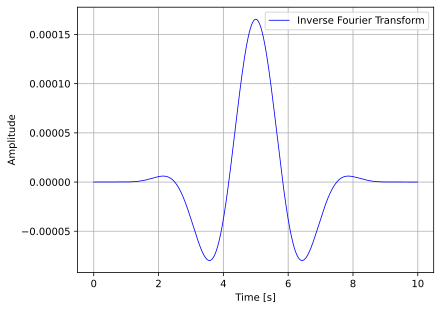

In [111]:
# Compute the inverse Fourier transform of the filter coefficients
n = 1000  # Number of points for the time-domain representation
filter_time_domain = np.fft.ifftshift(np.fft.ifft(np.concatenate((b, np.zeros(n - len(b))))))

# Generate the time array for the filter representation
y = np.arange(0, n) / fs

# Plot the inverse Fourier transform
plt.figure()
plt.plot(y, filter_time_domain.real, 'b-', label='Inverse Fourier Transform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

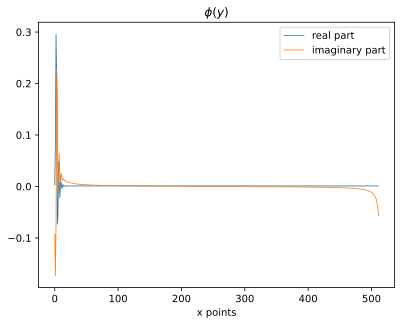

In [112]:
phiy = (scipy.fft.ifft(Gamma0))
y = np.arange(len(phiy))
plt.figure()
plot_real_imag(y, phiy, "$\phi(y)$")

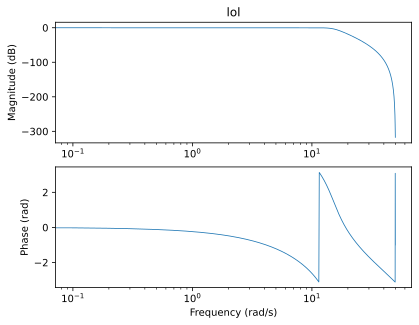

In [113]:
plot_resp_logy(w, (scipy.fft.fft(phiy)), "lol")

$$-\frac{y''}{2y'^2}=\phi(y)$$  
$y(0)=0$, $y'(0)=\epsilon(0)$

$$\begin{cases}\ddot{y} + 2\dot{y^2}\phi(y) = 0 \\
y(0) = 0\\
\dot{y(0)} = \epsilon(0)\end{cases}$$

Put $y[1]=\dot{y}$ and $y[0] = y$  

$$\dot{y[1]} =- 2y[1]^2\phi(y)$$

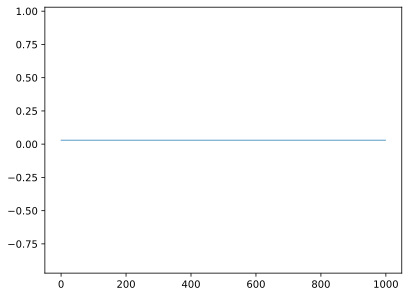

In [114]:
def phi(y):
    return y**2

# Define ODE
def f(x, u):
    return [u[1], -200000*np.power(u[1], 2)*phi(u[0])]

y0 = [0, 30*eps0]
L = 1
#L = 10  # assuming a value for L
phiy = np.linspace(0, L, num=1000)  # adjust the number of points as needed

# Solve ODE using solve_ivp
sol = solve_ivp(f, [0, L], y0, t_eval=phiy)

y_sol = sol.y[0]  # Extract the solution for y
plt.plot(np.gradient(y_sol/eps0))
plt.ylim([min(np.gradient(y_sol/eps0))-1, max(np.gradient(y_sol/eps0))+1])
plt.show()

In [115]:
np.gradient(y_sol/eps0)

array([0.03003003, 0.03003003, 0.03003003, 0.03003003, 0.03003003,
       0.03003003, 0.03003003, 0.03003003, 0.03003003, 0.03003003,
       0.03003003, 0.03003003, 0.03003003, 0.03003003, 0.03003003,
       0.03003003, 0.03003003, 0.03003003, 0.03003003, 0.03003003,
       0.03003003, 0.03003003, 0.03003003, 0.03003003, 0.03003003,
       0.03003003, 0.03003003, 0.03003003, 0.03003003, 0.03003003,
       0.03003003, 0.03003003, 0.03003003, 0.03003003, 0.03003003,
       0.03003003, 0.03003003, 0.03003003, 0.03003003, 0.03003003,
       0.03003003, 0.03003003, 0.03003003, 0.03003003, 0.03003003,
       0.03003003, 0.03003003, 0.03003003, 0.03003003, 0.03003003,
       0.03003003, 0.03003003, 0.03003003, 0.03003003, 0.03003003,
       0.03003003, 0.03003003, 0.03003003, 0.03003003, 0.03003003,
       0.03003003, 0.03003003, 0.03003003, 0.03003003, 0.03003003,
       0.03003003, 0.03003003, 0.03003003, 0.03003003, 0.03003003,
       0.03003003, 0.03003003, 0.03003003, 0.03003003, 0.03003